## Training

1. In these notes, we'll train a segmentation model to predict glacier, given the preprocessed patches created by the previous notes. Since we didn't have enough time to preprocess all the training data in the previous notebook, we use the code block below to download and extract [patches](https://uwmadison.box.com/shared/static/d54agxzb5g8ivr7hkac8nygqd6nrgrqr.gz) precomputed in advance. Note that there are only 67 patches in this archive -- this keeps the download relatively quick, and keeps us from getting in trouble with the people hosting these binder notebooks.

In [1]:
import urllib.request
import tensorflow as tf
import tarfile
from pathlib import Path
from data import create_dir, download_data
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# setup directory structure for download
data_dir = Path("/Users/app/Desktop/Remote Sensing Presentation")
process_dir = data_dir / "preprocessed"

2. The block below specifies some parameters of our learning algorithm, a U-Net segmentation model. Like most deep learning algorithms, we train it using a variant of stochastic optimization. The `lr` parameter below refers to the optimizer's learning rate. The binder notebooks we're running off of don't have GPUs. If they did, we could set `device: "cuda"`, and we'd be able to train the model much faster. We also had to limit the batch size, to avoid going over the memory limit imposed on these online notebooks.

In [12]:
args = {
    "batch_size": 1, # make this bigger if you are not running on binder
    "epochs": 30,
    "lr": 0.0001,
    "device": "cpu" # set to "cuda" if GPU is available
}

3. Our optimizer is going to need a way to stream in the preprocessed patches. This is accomplished using the `DataLoader` object below. If you tried visualizing the items in the data loader, you would see the same image-label pairs from the previous notebook. This step might seem mysterious if you haven't used a deep learning algorithm before. I'm deliberately avoiding an extended discussion on deep learning -- my emphasis here is on visualization and earth observation. There are also many [good references](https://sebastianraschka.com/books.html) on applied deep learning already.

In [13]:
from data import GlacierDataset
from torch.utils.data import DataLoader

paths = {
    "x": list((process_dir / "train").glob("x*")),
    "y": list((process_dir / "train").glob("y*"))
}
ds = GlacierDataset(paths["x"], paths["y"])
loader = DataLoader(ds, batch_size=args["batch_size"], shuffle=True)

4. Given a way of loading the training data, we can train our model. The parameters in the definition of the `Unet` correspond to 13 input sensor channels, 3 output classes (clean-ice glacier, debris-covered glacier, and background), and 4 layers.

5. We can try running the model below, but it will not finish in the time for this workshop (Though, with a larger batch size and a GPU, it doesn't take too long to converge.). We'll instead download a model that I already trained earlier. This model was also trained using all the training patches, and not just those from the Kokcha basin.

In [14]:
import torch.optim
from unet import Unet
from train import train_epoch

model = Unet(13, 3, 4, dropout=0.2).to(args["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])
Loss_Total=[];Loss_Box=[]
for epoch in range(args["epochs"]):
    l=train_epoch(model, loader, optimizer, args["device"], epoch)
    Loss_Total.append(l[0])
    Loss_Box.append(l[1])
    
#torch.save(model.state_dict(), data_dir / "model.pt")

Text(0, 0.5, 'Average Loss')

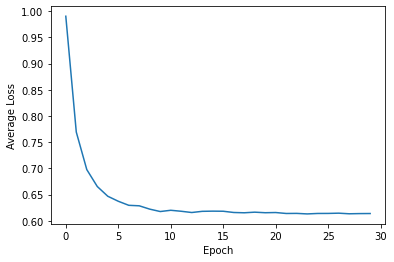

In [35]:
plt.plot(range(args["epochs"]),Loss_Total)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")

In [16]:
Box=[]
for x in Loss_Box:
    box=[]
    for y in x:
        v=y.detach().numpy().tolist()
        box.append(v)
    Box.append(box)


Text(0, 0.5, 'Loss')

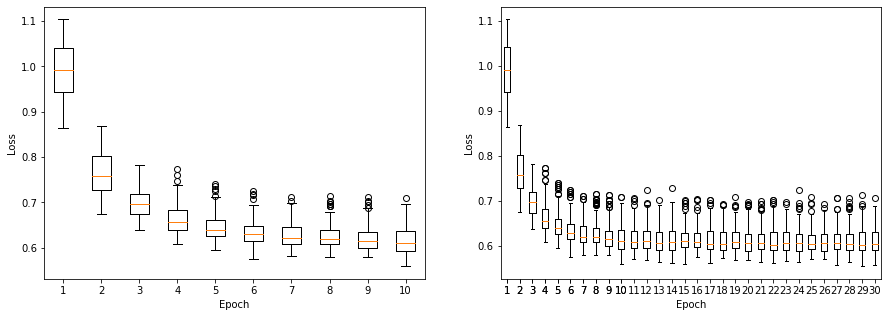

In [39]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))
figure=plt.boxplot(Box[0:10])
a=axs[0].boxplot(Box[0:10])
b=axs[1].boxplot(Box)
axs[0].set_xlabel('Epoch')
axs[1].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[1].set_ylabel('Loss')
#mean variance

 

In [18]:
import pandas as pd
df = pd.DataFrame(Box).T
df = df.rename(columns={k: f'Data{k+1}' for k in range(len(Box))}).reset_index()
df = pd.wide_to_long(df, stubnames = ['Data'], i = 'index', j = 'ID').reset_index()[['ID', 'Data']]

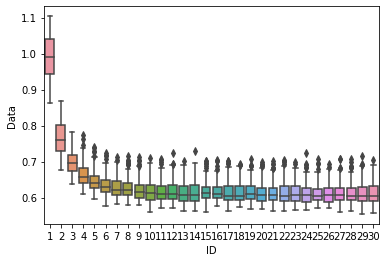

In [19]:
sns.boxplot(x='ID', y = 'Data', data = df,orient='v')

In [36]:
#x.shape torch.Size([20, 13, 512, 512])
#y.shape torch.Size([20, 3, 512, 512])
# batch * number of layer * length * width
#len(loader.dataset) 67
result=next(iter(loader)) 
x=result[0]
y=result[1]
y_hat = model(x)